# Import and Libraries

In [1]:
#uncomment the following to install required packages
#!pip install pandas numpy matplotlib plotly nbformat


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

RAW_PATH = Path("./Data/weather.csv")                 # adjust if needed
CLEAN_PATH = Path("./Data/weather_cleaned.csv")       # output
pd.set_option("display.max_columns", 50)


In [3]:
df_weather = pd.read_csv(RAW_PATH)
print("Loaded shape:", df_weather.shape)
df_weather.head(5)


Loaded shape: (1536, 21)


,Unnamed: 0,airport,time,summary,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipType,precipAccumulation,time2
0,1,Highland,2019-11-30 00:00:00,Overcast,0.0000,0.00,37.30,32.11,32.47,0.82,1019.58,6.70,8.06,141.090120,1.00,0,10.0,309.69,NaN,NaN,2019-11-30 00:00:00
1,2,Highland,2019-11-30 01:00:00,Possible Drizzle,0.0018,0.35,37.74,33.16,32.10,0.80,1018.31,5.77,7.58,110.003815,0.95,0,10.0,309.09,rain,NaN,2019-11-30 01:00:00
2,3,Highland,2019-11-30 02:00:00,Possible Drizzle,0.0062,0.54,37.60,31.13,32.41,0.83,1017.91,8.04,8.57,112.053620,1.00,0,10.0,308.70,rain,NaN,2019-11-30 02:00:00
3,4,Highland,2019-11-30 03:00:00,Light Rain,0.0135,0.71,36.60,29.78,31.76,0.83,1016.64,8.90,9.84,103.033220,1.00,0,10.0,309.40,rain,NaN,2019-11-30 03:00:00
4,5,Highland,2019-11-30 04:00:00,Overcast,0.0007,0.06,36.65,31.12,32.41,0.85,1017.49,6.95,8.95,104.085209,1.00,0,10.0,311.82,rain,NaN,2019-11-30 04:00:00


In [4]:
print(df_weather.columns.tolist())
df_weather.info()


['Unnamed: 0', 'airport', 'time', 'summary', 'precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'ozone', 'precipType', 'precipAccumulation', 'time2']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1536 non-null   int64  
 1   airport              1536 non-null   object 
 2   time                 1536 non-null   object 
 3   summary              1536 non-null   object 
 4   precipIntensity      1536 non-null   float64
 5   precipProbability    1536 non-null   float64
 6   temperature          1536 non-null   float64
 7   apparentTemperature  1536 non-null   float64
 8   dewPoint             1536 non-null   float64
 9   humidity             1536 non-null   float64
 

# Data Cleaning

Parsing column 'time' and developing a fallback using 'time2' in case 'time' is heavily NaN-filled. Here the checks carried out are possibly overly specific (for example looking at a ms level), but the idea is to build something that has some sort of elasticity in case the data source/structure changes

In [5]:

if "Unnamed: 0" in df_weather.columns:
    df_weather = df_weather.drop(columns=["Unnamed: 0"])

dt = pd.to_datetime(df_weather["time"], errors="coerce", utc=False) if "time" in df_weather.columns else pd.Series(pd.NaT, index=df_weather.index)

if (dt.isna().mean() > 0.5) and ("time2" in df_weather.columns):
    dt2 = pd.to_datetime(df_weather["time2"], errors="coerce", utc=False)
    if dt2.notna().sum() > dt.notna().sum():
        dt = dt2

if (dt.isna().mean() > 0.5) and ("time" in df_weather.columns):
    try:
        dt_try = pd.to_datetime(df_weather["time"].astype(float), unit="s", errors="coerce")
        if dt_try.notna().sum() > dt.notna().sum():
            dt = dt_try
        else:
            dt_try_ms = pd.to_datetime(df_weather["time"].astype(float), unit="ms", errors="coerce")
            if dt_try_ms.notna().sum() > dt.notna().sum():
                dt = dt_try_ms
    except Exception:
        pass

df_weather["datetime"] = dt
print("Missing datetime after parsing:", df_weather["datetime"].isna().sum())

# Drop rows with no usable timestamp and sort
df_weather = df_weather.dropna(subset=["datetime"]).sort_values("datetime").reset_index(drop=True)
df_weather[["airport", "datetime"]].head(5)


Missing datetime after parsing: 0


,airport,datetime
0,Eureka,2019-11-29 23:00:00
1,Highland,2019-11-30 00:00:00
2,Eureka,2019-11-30 00:00:00
3,Eureka,2019-11-30 01:00:00
4,Highland,2019-11-30 01:00:00


In the following step, relevant columns have been kept, and columns with numeric values have been ensured to be in the correct format

In [6]:
keep = [
    "datetime", "airport", "summary", "precipIntensity", "precipProbability", "precipType",
    "precipAccumulation", "temperature", "apparentTemperature", "dewPoint", "humidity",
    "pressure", "windSpeed", "windGust", "windBearing", "cloudCover", "uvIndex",
    "visibility", "ozone"
]
keep = [c for c in keep if c in df_weather.columns]
df_weather = df_weather[keep].copy()

numeric_cols = [
    "precipIntensity", "precipProbability", "precipAccumulation", "temperature",
    "apparentTemperature", "dewPoint", "humidity", "pressure", "windSpeed",
    "windGust", "windBearing", "cloudCover", "uvIndex", "visibility", "ozone"
]
for c in [c for c in numeric_cols if c in df_weather.columns]:
    df_weather[c] = pd.to_numeric(df_weather[c], errors="coerce")

df_weather.head(5)


,datetime,airport,summary,precipIntensity,precipProbability,precipType,precipAccumulation,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone
0,2019-11-29 23:00:00,Eureka,Clear,0.0000,0.00,NaN,NaN,30.01,19.83,12.32,0.48,1015.48,12.88,12.85,320.017083,0.19,0,10.0,355.66
1,2019-11-30 00:00:00,Highland,Overcast,0.0000,0.00,NaN,NaN,37.30,32.11,32.47,0.82,1019.58,6.70,8.06,141.090120,1.00,0,10.0,309.69
2,2019-11-30 00:00:00,Eureka,Mostly Cloudy,0.0000,0.00,NaN,NaN,30.10,18.94,10.81,0.45,1015.12,15.71,15.74,321.076483,0.69,0,10.0,355.91
3,2019-11-30 01:00:00,Eureka,Mostly Cloudy,0.0000,0.00,NaN,NaN,30.17,19.74,12.41,0.48,1015.24,12.89,12.82,315.058190,0.68,0,10.0,359.78
4,2019-11-30 01:00:00,Highland,Possible Drizzle,0.0018,0.35,rain,NaN,37.74,33.16,32.10,0.80,1018.31,5.77,7.58,110.003815,0.95,0,10.0,309.09


Some basic sanity checks (Missing values per column, duplicate timestamps within airport, time coverage and sampling frequency)

In [7]:
print("Missing values by column:")
print(df_weather.isna().sum().sort_values(ascending=False))

# If multiple airports present, check duplicates per (airport, datetime)
if "airport" in df_weather.columns and df_weather["airport"].nunique() > 1:
    dups = df_weather.duplicated(subset=["airport", "datetime"]).sum()
    print("Duplicate (airport, datetime) rows:", dups)
    if dups > 0:
        # Keep the last observation in case of duplicates (simple, deterministic)
        df_weather = df_weather.drop_duplicates(subset=["airport", "datetime"], keep="last")
else:
    dups = df_weather.duplicated(subset=["datetime"]).sum()
    print("Duplicate datetime rows:", dups)
    if dups > 0:
        df_weather = df_weather.drop_duplicates(subset=["datetime"], keep="last")

date_min, date_max = df_weather["datetime"].min(), df_weather["datetime"].max()
print("Date coverage:", date_min, "→", date_max)

# Sampling frequency check (rough): median delta
delta = df_weather["datetime"].diff().dropna()
print("Median sampling interval:", delta.median())


Missing values by column:
precipAccumulation     1455
precipType             1220
datetime                  0
summary                   0
airport                   0
precipProbability         0
precipIntensity           0
temperature               0
apparentTemperature       0
dewPoint                  0
humidity                  0
pressure                  0
windSpeed                 0
windGust                  0
windBearing               0
cloudCover                0
uvIndex                   0
visibility                0
ozone                     0
dtype: int64
Duplicate (airport, datetime) rows: 0
Date coverage: 2019-11-29 23:00:00 → 2019-12-31 23:00:00
Median sampling interval: 0 days 01:00:00


Validation of hourly airport data - at this stage the dataset was kept in its entirety. The idea is to filter it later on, focusing on HIX data, but at the same time providing a soldi structure that can be used for multiple airports when/if needed. Moreover, in this case the code works smoothly as the data is hourly, and always at hh:00. In case the data was more sparse or with inconsistent timestamps, a strategy could have been resampling the data and producing hourly averages, so to have cleaner data

In [8]:
has_multi_airports = ("airport" in df_weather.columns and df_weather["airport"].nunique() > 1)

def _validate_hourly(df, label="(all)"):
    df = df.sort_values("datetime")
    # Check median and unique step
    deltas = df["datetime"].diff().dropna()
    median_step = deltas.median()
    unique_steps = deltas.value_counts().index.astype("timedelta64[s]").unique()

    # duplicates check (per airport if applicable)
    dup_count = df.duplicated(subset=["datetime"]).sum() if "airport" not in df.columns else \
                df.duplicated(subset=["airport","datetime"]).sum()

    # Gaps (count missing expected hours between min and max)
    full_index = pd.date_range(df["datetime"].min(), df["datetime"].max(), freq="1H")
    gap_count = len(full_index.difference(df["datetime"].dt.floor("H").unique()))

    print(f"\n Hourly validation for {label}")
    print("Rows:", len(df))
    print("Median step:", median_step)
    print("Unique steps (sec):", list(unique_steps))
    print("Duplicate timestamp rows:", dup_count)
    print("Missing hourly slots (gaps):", gap_count)

    # soft warnings (wont stop execution)
    if median_step != pd.Timedelta(hours=1):
        print("⚠️  Median step is not 1H — data may not be strictly hourly.")
    if dup_count > 0:
        print("⚠️  Found duplicate timestamps — consider deduplicating.")
    if gap_count > 0:
        print("⚠️  Found gaps — consider resampling or forward-filling before merge.")

    return df

if has_multi_airports:
    frames = []
    for ap, df_ in df_weather.groupby("airport", sort=False):
        frames.append(_validate_hourly(df_, label=ap))
    df_weather = pd.concat(frames, ignore_index=True).sort_values(["datetime","airport"])
else:
    df_weather = _validate_hourly(df_weather).sort_values("datetime")

print("\n✅ Skipped resampling because data is already hourly.")
df_weather.head(5)



 Hourly validation for Eureka
Rows: 768
Median step: 0 days 01:00:00
Unique steps (sec): [Timedelta('0 days 01:00:00')]
Duplicate timestamp rows: 0
Missing hourly slots (gaps): 0

 Hourly validation for Highland
Rows: 768
Median step: 0 days 01:00:00
Unique steps (sec): [Timedelta('0 days 01:00:00')]
Duplicate timestamp rows: 0
Missing hourly slots (gaps): 0

✅ Skipped resampling because data is already hourly.


C:\Users\MicheleCoaro\AppData\Local\Temp\ipykernel_8936\1592534167.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(df["datetime"].min(), df["datetime"].max(), freq="1H")
C:\Users\MicheleCoaro\AppData\Local\Temp\ipykernel_8936\1592534167.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  gap_count = len(full_index.difference(df["datetime"].dt.floor("H").unique()))
C:\Users\MicheleCoaro\AppData\Local\Temp\ipykernel_8936\1592534167.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(df["datetime"].min(), df["datetime"].max(), freq="1H")
C:\Users\MicheleCoaro\AppData\Local\Temp\ipykernel_8936\1592534167.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  gap_count = len(full_index.difference(df["datetime"].dt.floor(

,datetime,airport,summary,precipIntensity,precipProbability,precipType,precipAccumulation,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone
0,2019-11-29 23:00:00,Eureka,Clear,0.0000,0.00,NaN,NaN,30.01,19.83,12.32,0.48,1015.48,12.88,12.85,320.017083,0.19,0,10.0,355.66
1,2019-11-30 00:00:00,Eureka,Mostly Cloudy,0.0000,0.00,NaN,NaN,30.10,18.94,10.81,0.45,1015.12,15.71,15.74,321.076483,0.69,0,10.0,355.91
768,2019-11-30 00:00:00,Highland,Overcast,0.0000,0.00,NaN,NaN,37.30,32.11,32.47,0.82,1019.58,6.70,8.06,141.090120,1.00,0,10.0,309.69
2,2019-11-30 01:00:00,Eureka,Mostly Cloudy,0.0000,0.00,NaN,NaN,30.17,19.74,12.41,0.48,1015.24,12.89,12.82,315.058190,0.68,0,10.0,359.78
769,2019-11-30 01:00:00,Highland,Possible Drizzle,0.0018,0.35,rain,NaN,37.74,33.16,32.10,0.80,1018.31,5.77,7.58,110.003815,0.95,0,10.0,309.09


Derivation of some minimal 'flags'

is_low_vis -> visibility <5 miles 

is_precip (precipIntensity > 0 or precProb <0.5)

In [9]:
if "visibility" in df_weather.columns:
    df_weather["is_low_vis"] = (df_weather["visibility"] < 5).astype("Int8")
else:
    df_weather["is_low_vis"] = pd.NA

has_intensity = "precipIntensity" in df_weather.columns
has_probability = "precipProbability" in df_weather.columns
if has_intensity or has_probability:
    cond = pd.Series(False, index=df_weather.index)
    if has_intensity:
        cond = cond | (df_weather["precipIntensity"].fillna(0) > 0)
    if has_probability:
        cond = cond | (df_weather["precipProbability"].fillna(0) >= 0.5)
    df_weather["is_precip"] = cond.astype("Int8")
else:
    df_weather["is_precip"] = pd.NA

if {"temperature", "dewPoint"}.issubset(df_weather.columns):
    df_weather["temp_dew_diff_F"] = (df_weather["temperature"] - df_weather["dewPoint"]).astype(float)
else:
    df_weather["temp_dew_diff_F"] = np.nan

df_weather[["datetime","airport","visibility","is_low_vis","precipIntensity","precipProbability","is_precip","temp_dew_diff_F"]].head(8)


,datetime,airport,visibility,is_low_vis,precipIntensity,precipProbability,is_precip,temp_dew_diff_F
0,2019-11-29 23:00:00,Eureka,10.0,0,0.0000,0.00,0,17.69
1,2019-11-30 00:00:00,Eureka,10.0,0,0.0000,0.00,0,19.29
768,2019-11-30 00:00:00,Highland,10.0,0,0.0000,0.00,0,4.83
2,2019-11-30 01:00:00,Eureka,10.0,0,0.0000,0.00,0,17.76
769,2019-11-30 01:00:00,Highland,10.0,0,0.0018,0.35,1,5.64
3,2019-11-30 02:00:00,Eureka,10.0,0,0.0000,0.00,0,15.96
770,2019-11-30 02:00:00,Highland,10.0,0,0.0062,0.54,1,5.19
4,2019-11-30 03:00:00,Eureka,10.0,0,0.0000,0.00,0,17.33


Some EDA visualization, here again on the whole dataset, to have some visual understanding of the data shape

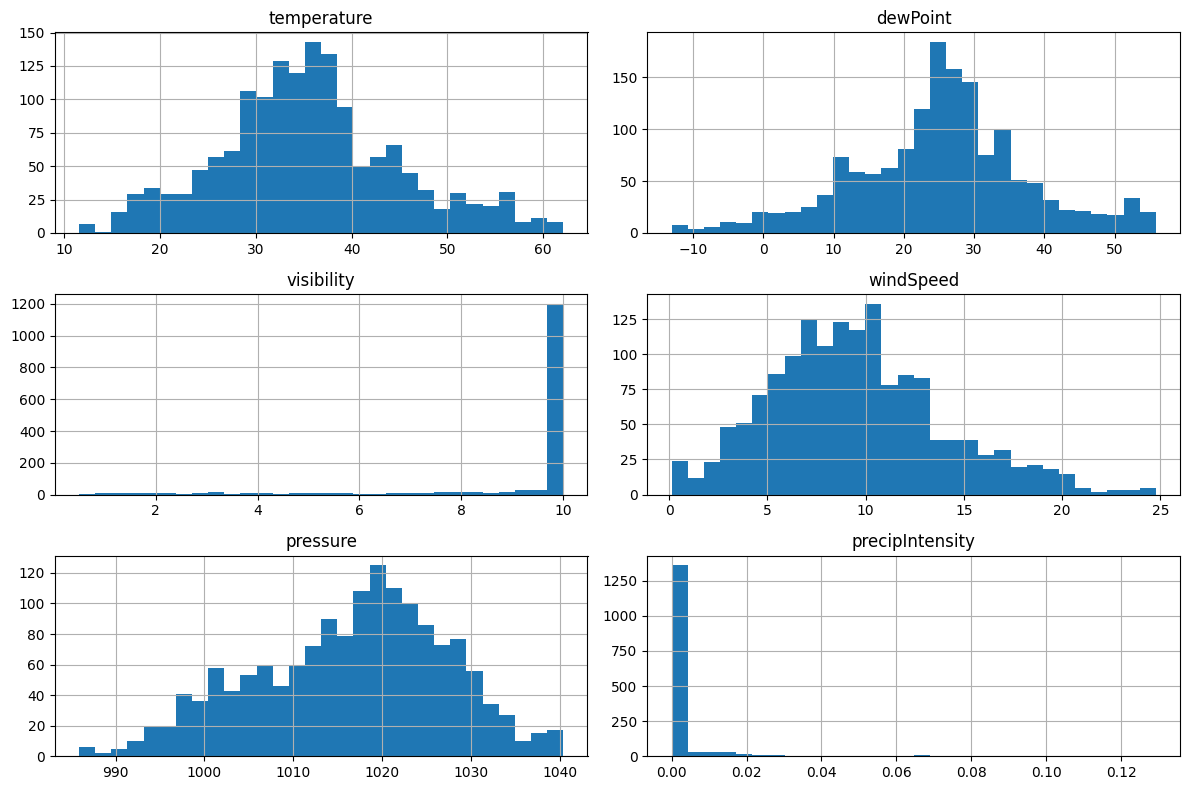

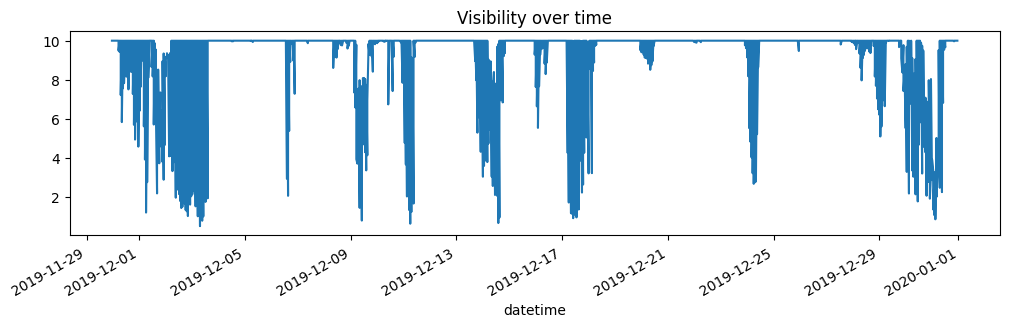

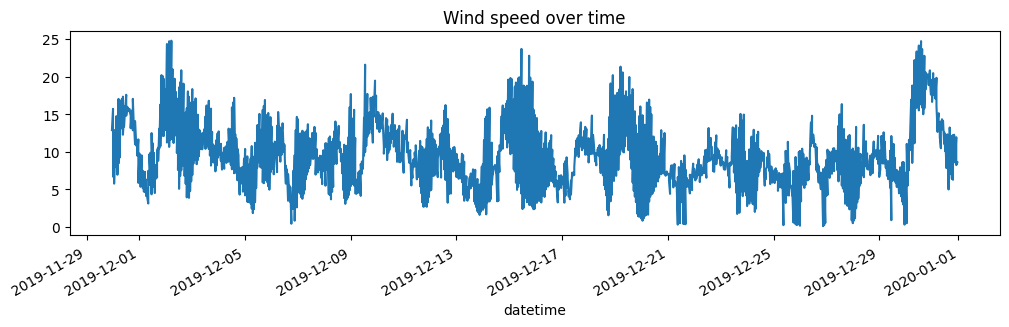

In [10]:

num_preview = [c for c in ["temperature","dewPoint","visibility","windSpeed","pressure","precipIntensity"] if c in df_weather.columns]
if num_preview:
    ax = df_weather[num_preview].hist(bins=30, figsize=(12, 8))
    plt.tight_layout()
    plt.show()

# Time series glimpse (if single airport or after filtering)
if "visibility" in df_weather.columns:
    df_weather.set_index("datetime")["visibility"].plot(figsize=(12, 3), title="Visibility over time")
    plt.show()

if "windSpeed" in df_weather.columns:
    df_weather.set_index("datetime")["windSpeed"].plot(figsize=(12, 3), title="Wind speed over time")
    plt.show()


In [11]:
df_weather.to_csv(CLEAN_PATH, index=False)
CLEAN_PATH, CLEAN_PATH.exists()


(WindowsPath('Data/weather_cleaned.csv'), True)

# Data Filtering

Keeping only HIX data, as that is what interests us

In [12]:
df_weather_HIX = pd.read_csv(CLEAN_PATH)
df_weather_HIX = df_weather_HIX[df_weather_HIX["airport"] == "Highland"].reset_index(drop=True)
df_weather_HIX['airport'] = "HIX"
df_weather_HIX.head(5)


,datetime,airport,summary,precipIntensity,precipProbability,precipType,precipAccumulation,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,is_low_vis,is_precip,temp_dew_diff_F
0,2019-11-30 00:00:00,HIX,Overcast,0.0000,0.00,NaN,NaN,37.30,32.11,32.47,0.82,1019.58,6.70,8.06,141.090120,1.00,0,10.0,309.69,0,0,4.83
1,2019-11-30 01:00:00,HIX,Possible Drizzle,0.0018,0.35,rain,NaN,37.74,33.16,32.10,0.80,1018.31,5.77,7.58,110.003815,0.95,0,10.0,309.09,0,1,5.64
2,2019-11-30 02:00:00,HIX,Possible Drizzle,0.0062,0.54,rain,NaN,37.60,31.13,32.41,0.83,1017.91,8.04,8.57,112.053620,1.00,0,10.0,308.70,0,1,5.19
3,2019-11-30 03:00:00,HIX,Light Rain,0.0135,0.71,rain,NaN,36.60,29.78,31.76,0.83,1016.64,8.90,9.84,103.033220,1.00,0,10.0,309.40,0,1,4.84
4,2019-11-30 04:00:00,HIX,Overcast,0.0007,0.06,rain,NaN,36.65,31.12,32.41,0.85,1017.49,6.95,8.95,104.085209,1.00,0,10.0,311.82,0,1,4.24


In [13]:
df_weather_HIX.to_csv("./Data/weather_cleaned_HIX.csv", index=False)

# KPI and Insights

The idea here is to derive from the data some type of indicator or variable that enables us to better understande the data characteristics and trends. The final goal is to enrich comprehension of this data, so that the quality of the analysis carried out in the dedicated notebook can be augmented.

First of all, let's define (arbitrarily) adverse conditions

In [14]:
df_weather_HIX["is_precip"] = (df_weather_HIX["precipIntensity"].fillna(0) > 0).astype(int)
df_weather_HIX["is_low_vis"] = (df_weather_HIX["visibility"] < 5).astype(int)
df_weather_HIX["is_high_wind"] = (df_weather_HIX["windSpeed"] > 20).astype(int)
df_weather_HIX["dewpoint_spread"] = df_weather_HIX["temperature"] - df_weather_HIX["dewPoint"]


Then, let's create some daily KPI aggreagation for grouped viewing

In [15]:
daily_kpis = df_weather_HIX.groupby("datetime").agg(
    precip_hours = ("is_precip","sum"),
    low_vis_hours = ("is_low_vis","sum"),
    high_wind_hours = ("is_high_wind","sum"),
    mean_temp = ("temperature","mean"),
    min_temp = ("temperature","min"),
    max_temp = ("temperature","max"),
    mean_wind = ("windSpeed","mean"),
    gust_95p = ("windGust", lambda x: np.nanpercentile(x,95)),
    dewpoint_spread_mean = ("dewpoint_spread","mean"),
)
display(daily_kpis.describe())


,precip_hours,low_vis_hours,high_wind_hours,mean_temp,min_temp,max_temp,mean_wind,gust_95p,dewpoint_spread_mean
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.130208,0.026042,0.002604,34.280169,34.280169,34.280169,8.219297,10.850469,8.711133
std,0.336752,0.159363,0.050998,9.826115,9.826115,9.826115,3.636964,6.227166,4.803855
min,0.000000,0.000000,0.000000,11.530000,11.530000,11.530000,0.510000,0.750000,0.360000
25%,0.000000,0.000000,0.000000,27.570000,27.570000,27.570000,5.675000,6.757500,5.685000
50%,0.000000,0.000000,0.000000,34.325000,34.325000,34.325000,8.085000,9.940000,7.590000
75%,0.000000,0.000000,0.000000,39.912500,39.912500,39.912500,10.402500,13.247500,11.060000
max,1.000000,1.000000,1.000000,61.750000,61.750000,61.750000,20.300000,34.300000,32.000000


Next, let's compute global KPIs

In [16]:
weather_summary = {
    "Total hours": len(df_weather_HIX),
    "Hours with precipitation": df_weather_HIX["is_precip"].sum(),
    "Share precip hours (%)": 100 * df_weather_HIX["is_precip"].mean(),
    "Hours with low visibility": df_weather_HIX["is_low_vis"].sum(),
    "Hours with high winds": df_weather_HIX["is_high_wind"].sum(),
    "Avg temperature (°F)": df_weather_HIX["temperature"].mean(),
    "Avg dewpoint spread (°F)": df_weather_HIX["dewpoint_spread"].mean(),
}
pd.DataFrame(weather_summary, index=["HIX"])


,Total hours,Hours with precipitation,Share precip hours (%),Hours with low visibility,Hours with high winds,Avg temperature (°F),Avg dewpoint spread (°F)
HIX,768,100,13.020833,20,2,34.280169,8.711133


In [17]:
import plotly.express as px
import plotly.graph_objects as go

In [18]:
w = df_weather_HIX.copy()
w["datetime"] = pd.to_datetime(w["datetime"])
w = w.sort_values("datetime").reset_index(drop=True)
w["date"] = w["datetime"].dt.date
w["hour"] = w["datetime"].dt.hour
w["dewpoint_spread"] = w["temperature"] - w["dewPoint"]


In [19]:
LOW_VIS_MI = 5     # <5 miles considered low visibility, as done ppreviously
HIGH_WIND_MPH = 10.34  # wind with speed between 50 and 61 km/h (31-37 mph) is considered strong wind by https://www.meteosvizzera.admin.ch/dam/jcr:08425f94-9261-4332-bee7-56ef54fe94a8/Beaufort_Tabelle_IT_gam.pdf, however, this number has been recomputed in the following analysis, due to the shape of the data
PRECIP_EPS  = 0.0  # threshold for considering precipitation, if greater than 0.0, then we consider precipitation to be happening

w["is_precip"]   = (w["precipIntensity"].fillna(0) > PRECIP_EPS).astype(int)
w["is_low_vis"]  = (w["visibility"] < LOW_VIS_MI).astype(int)
w["is_high_wind"]= (w["windSpeed"] > HIGH_WIND_MPH).astype(int)


creating a daily Kpi frame, to be sed for some plots

In [20]:
daily = w.groupby("date", as_index=False).agg(
    precip_hours   = ("is_precip","sum"),
    low_vis_hours  = ("is_low_vis","sum"),
    high_wind_hours= ("is_high_wind","sum"),
    mean_temp      = ("temperature","mean"),
    gust_95p       = ("windGust", lambda x: np.nanpercentile(x,95)),
)

In [21]:
daily_long = daily.melt(
    id_vars=["date","mean_temp","gust_95p"],
    value_vars=["precip_hours","low_vis_hours","high_wind_hours"],
    var_name="condition", value_name="hours"
)

fig1 = px.bar(
    daily_long, x="date", y="hours", color="condition",
    title="HIX • Daily Adverse-Condition Hours",
    hover_data={"mean_temp":":.1f", "gust_95p":":.1f"}
)
fig1.update_layout(barmode="stack", 
                   xaxis_title="", 
                   yaxis_title="Hours",
                   template = 'plotly_dark'
                   )
fig1.show()


In [22]:
fig2 = go.Figure()

# temperature line
fig2.add_trace(go.Scatter(
    x=w["datetime"], y=w["temperature"],
    mode="lines", name="Temperature",
    hovertemplate="Time: %{x}<br>Temp: %{y:.1f}°F<extra></extra>"
))

# precip intensity on secondary y
fig2.add_trace(go.Scatter(
    x=w["datetime"], y=w["precipIntensity"],
    mode="lines", name="Precip Intensity",
    yaxis="y2",
    hovertemplate="Time: %{x}<br>Precip Intensity: %{y:.2f}<extra></extra>"
))

# shaded low-visibility regions
lv = w[w["is_low_vis"]==1]
fig2.add_trace(go.Scatter(
    x=lv["datetime"], y=[lv["precipIntensity"].max()]*len(lv),
    mode="markers", name="Low Visibility (<5 mi)",
    marker=dict(size=6, opacity=0.3),
    yaxis="y2",
    hovertemplate="Time: %{x}<br>Low visibility<extra></extra>"
))

fig2.update_layout(
    title="HIX • Temperature & Precip (Low-Vis hours highlighted)",
    xaxis_title="",
    yaxis=dict(title="Temperature (°F)"),
    yaxis2=dict(title="Precip Intensity", overlaying="y", side="right"),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
    template = 'plotly_dark'
)
fig2.show()


In [23]:
p95 = np.nanpercentile(w["windSpeed"], 95)

fig3 = px.histogram(
    w, x="windSpeed", nbins=30,
    title=f"HIX • Wind Speed Distribution (95th ≈ {p95:.1f})",
    template = 'plotly_dark',
    marginal="box"
)
fig3.add_vline(x=p95, line_dash="dash", annotation_text="95th")
fig3.update_layout(xaxis_title="Wind Speed", yaxis_title="Hours")
fig3.show()


This wind data distribution makes me reconsider the source I used for the previous setting of the threshold, which was set at 31 mph (55kmh). Seeing the shape of this data column, I think a good proxy is considering "strong" wind those that lie beyond the 3rd quartile

In [24]:
fig4 = px.scatter(
    w, x="temperature", y="visibility",
    color="precipIntensity", color_continuous_scale="Blues",
    title="HIX • Temperature vs. Visibility (color = Precip Intensity)",
    template = 'plotly_dark',
    hover_data={"dewpoint_spread":":.1f","windGust":":.1f","hour":True}
)
fig4.update_layout(xaxis_title="Temperature (°F)", yaxis_title="Visibility (mi)")
fig4.show()


In [25]:
fig6 = go.Figure()
fig6.add_trace(go.Scatter(x=w["datetime"], y=w["dewpoint_spread"],
                          mode="lines", name="Dewpoint Spread"))
fig6.add_hline(y=2, line_dash="dot", annotation_text="Low spread (~icing risk)")
fig6.update_layout(title="HIX • Dewpoint Spread over Time", template = 'plotly_dark',
                   xaxis_title="", yaxis_title="°F")
fig6.show()
